In [ ]:
import warnings
warnings.filterwarnings("ignore")
%pip install river
%pip install catboost
%pip install lightgbm
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached catboost-1.2.7.tar.gz (71.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [145 lines of output]
        Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached jupyterlab-3.6.8-py3-none-any.whl.metadata (12 kB)
        Using cached conan-1.66.0.tar.gz (789 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached ipython-8.32.0-py3-none-any.whl.metadata (5.0 kB)
        Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
        Using cached tornado-6.4.2-cp38-abi3-win_amd64.whl.metadat

LCCDE: Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
df = pd.read_csv("CICIDS2017_sample_km.csv")

In [ ]:
df.columns = df.columns.str.strip()  # Remove leading spaces in column names

In [ ]:
df.Label.value_counts()

,count
Label,
DDoS,128027
BENIGN,97718


In [ ]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

SMOTE to solve class Imbalance

In [ ]:
pd.Series(y_train).value_counts()

,count
Label,
DDoS,102367
BENIGN,78229


In [ ]:
pip install --upgrade imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Ensure y_train matches X_train

smote=SMOTE(sampling_strategy={2:1000,4:1000})

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
pd.Series(y_train).value_counts()

,count
Label,
DDoS,102367
BENIGN,78229


Training LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 102367, number of negative: 78229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14146
[LightGBM] [Info] Number of data points in the train set: 180596, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566829 -> initscore=0.268924
[LightGBM] [Info] Start training from score 0.268924
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19489
        DDoS       1.00      1.00      1.00     25660

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149

Accuracy of LightGBM: 0.9999114044

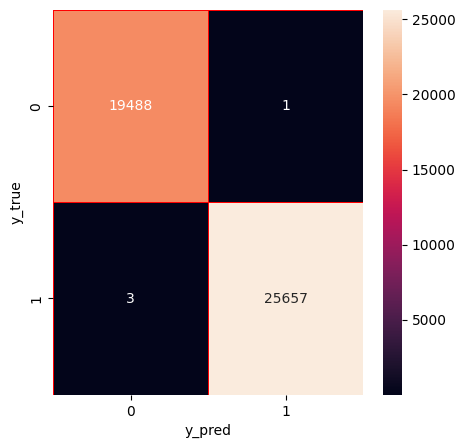

CPU times: user 8.78 s, sys: 300 ms, total: 9.08 s
Wall time: 9.02 s


In [ ]:
? %%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

XGBoost

In [ ]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

CatBoost

In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

KNN

In [ ]:
%%time

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluation
print("\nKNN Evaluation:")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn, average='weighted'):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()


SVM

In [ ]:
%%time

# Train SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluation
print("\nSVM Evaluation:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()


In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [ ]:
model

**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

LCCDE Prediction

In [ ]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence

                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3

        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0])

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [ ]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)

In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.